# 数据与问题描述

## 赛题介绍

蚂蚁金服拥有上亿会员并且业务场景中每天都涉及大量的资金流入和流出，面对如此庞大的用户群，资金管理压力会非常大。在既保证资金流动性风险最小，又满足日常业务运转的情况下，精准地预测资金的流入流出情况变得尤为重要。此届大赛以《资金流入流出预测》为题，期望参赛者能够通过对例如余额宝用户的申购赎回数据的把握，精准预测未来每日的资金流入流出情况。对货币基金而言，资金流入意味着申购行为，资金流出为赎回行为。

## 赛题数据

竞赛中使用的数据主要包含四个部分，分别为用户基本信息数据、用户申购赎回数据、收益率表和银行间拆借利率表。下面分别介绍四组数据。具体信息请访问[此处](https://tianchi.shuju.aliyun.com/getStart/introduction.htm?spm=5176.100066.333.9.Hevw7I&raceId=231573)

1.用户信息表 

用户信息表： user_profile_table 。 我们总共随机抽取了约 3 万用户，其中部分用户在 2014 年 9 月份第一次出现，这部分用户只在测试数据中 。因此用户信息表是约 2.8 万 个用户的基本数据，在原始数据的基础上处理后，主要包含了用户的性别、城市和星座。

2.用户申购赎回数据表 

用户申购赎回数据表： user_balance_table 。里面有 20130701 至 20140831 申购和赎回信息、以及所有的子类目信息， 数据经过脱敏处理。脱敏之后的数据，基本保持了原数据趋势。数据主要包括用户操作时间和操作记录，其中操作记录包括申购和赎回两个部分。金额的单位是分，即 0.01 元人民币。 如果用户今日消费总量为0，即consume_amt=0，则四个字类目为空。

3.收益率表 
收益表为余额宝在 14 个月内的收益率表： mfd_day_share_interest。

4.上海银行间同业拆放利率（Shibor）表 

银行间拆借利率表是 14 个月期间银行之间的拆借利率（皆为年化利率）： mfd_bank_shibor 。



## 数据处理

1. 计算每日总的购买和赎回

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import pyflux as pf

In [2]:
data_dir = "/Users/EricDoug/Documents/datas/alis/purchase_redeem/alipay"
user_balance_file = os.path.join(data_dir, "user_balance_table.csv")
user_profile_file = os.path.join(data_dir, "user_profile_table.csv")

In [3]:
user_balance_data = pd.read_csv(user_balance_file)
user_balance_data.columns = ['user_id', 'report_date', 'tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt', 'category1', 'category2', 'category3', 'category4']

In [4]:
user_balance_data['report_date'] = user_balance_data['report_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [ ]:
# user_balance_data.head(5)

### 每天的申购金额统计

In [5]:
totalpurchase_per_day = user_balance_data['total_purchase_amt'].groupby(user_balance_data['report_date']).sum()

### 每天的赎回金额统计

In [6]:
totalredeem_per_day = user_balance_data['total_redeem_amt'].groupby(user_balance_data['report_date']).sum()

### 可视化每天的申购与赎回

In [7]:
totalpurchase_per_day.to_csv(os.path.join(data_dir, "totalpurchase_per_day.csv"))
totalredeem_per_day.to_csv(os.path.join(data_dir, "totalredeem_per_day.csv"))

In [8]:
start_date = pd.datetime(2013,7,1)
end_date = pd.datetime(2014,8,31)
date = pd.date_range(start_date, end_date)

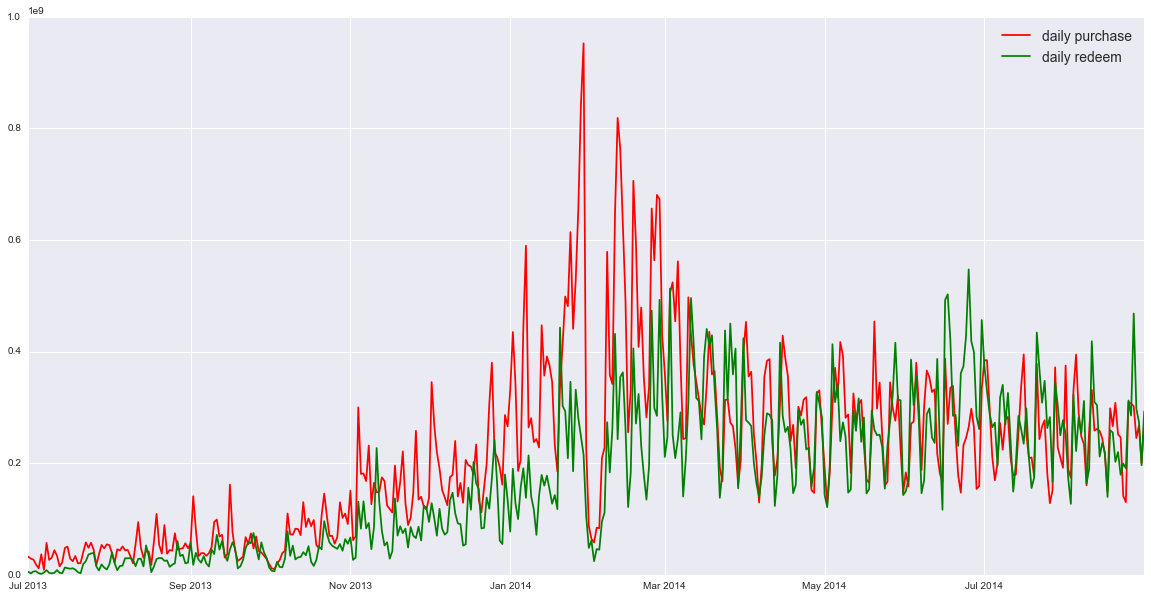

In [9]:
fig = plt.figure(figsize=(20,10))
fig = plt.plot(date, totalpurchase_per_day, 'r', label='daily purchase')
fig = plt.plot(date, totalredeem_per_day, 'g', label='daily redeem')
fig = plt.legend(loc='upper right', shadow=True, fontsize=14)

### 数据分析

1. 由于2013年6月份支付宝开始上线，刚开始的用户量不是很大，活跃不是很高，所以每天的购买和赎回与需要预测的数值应该不是一个数量级，所以2013年的数据仅作为参考，实际输入到模型的数据是2014年的数据。

2. 将2014年4月至2014年7月的数据作为训练集，2014年8月的数据作为测试集。

将2014年的4月到7月的数据作为训练集，8月的数据作为测试集。

In [10]:
train_start_date = pd.datetime(2014,4,1)
train_end_date = pd.datetime(2014,7,31)
train_date = pd.date_range(train_start_date, train_end_date)
test_start_date = pd.datetime(2014,8,1)
test_end_date = pd.datetime(2014,8,31)
test_date = pd.date_range(test_start_date, test_end_date)

In [11]:
using_data = user_balance_data[user_balance_data.report_date >= train_start_date]

In [12]:
using_purchase_data = using_data['total_purchase_amt'].groupby(using_data['report_date']).sum()

In [13]:
using_redeem_data = using_data['total_redeem_amt'].groupby(using_data['report_date']).sum()

In [14]:
train_data = using_data[using_data.report_date <= train_end_date]

In [15]:
test_data = using_data[using_data.report_date >= test_start_date]

In [16]:
#test_data = test_data[test_data.report_date <= test_end_date]

In [38]:
train_purchase_data = train_data['total_purchase_amt'].groupby(train_data['report_date']).sum()
test_purchase_data = test_data['total_purchase_amt'].groupby(test_data['report_date']).sum()
train_redeem_data = train_data['total_redeem_amt'].groupby(train_data['report_date']).sum()
test_redeem_data = test_data['total_redeem_amt'].groupby(test_data['report_date']).sum()

In [18]:
train_date = pd.date_range(train_start_date,train_end_date)
test_date = pd.date_range(test_start_date, test_end_date)

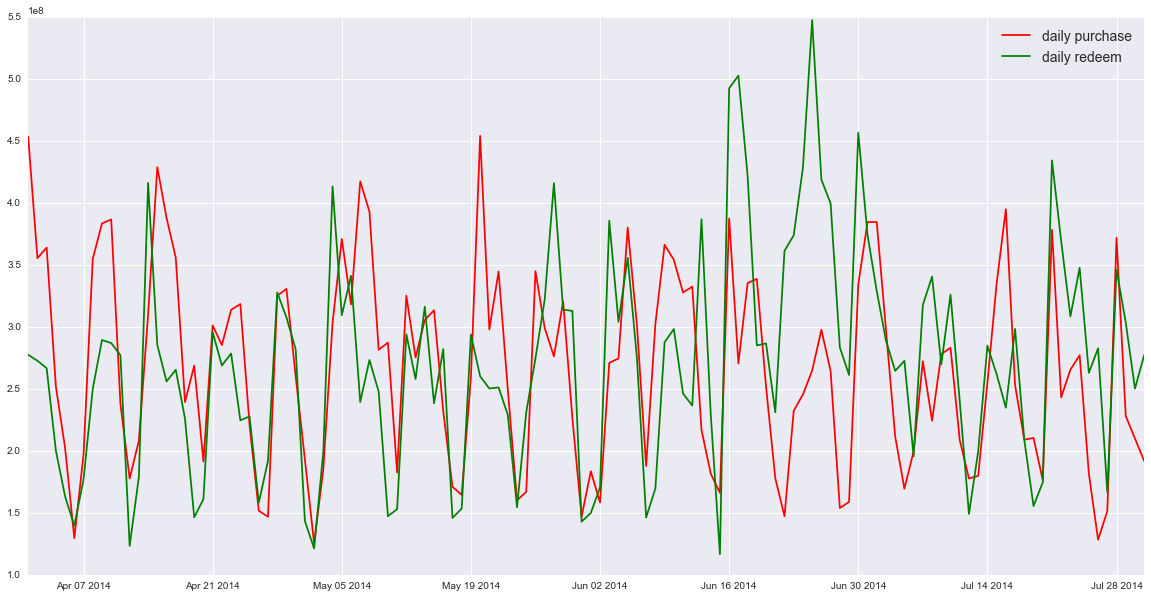

In [19]:
fig = plt.figure(figsize=(20,10))
fig = plt.plot(train_date, train_purchase_data, 'r', label='daily purchase')
fig = plt.plot(train_date, train_redeem_data, 'g', label='daily redeem')
fig = plt.legend(loc='upper right',fontsize=14)

# 模型1 移动平均模型(MA)

研究时间序列时，经常会用到移动平均值。移动平均法需要规定一个窗口，它限定了每一眼能看到数据的数量，窗口每前移一个周期，其中的数据都要计算一次均值:

$$SMA=\frac{a_m+a_{m-1}+ ... + a_{m-(n-1)}}{n}$$

不同类型的移动平均法主要区别在于求平均值时所用的权重，如指数移动平均法，权重随时间的变化以指数的形式递减。

$$EMA_n = EMA_{n-1} + \alpha (p_n - EMA_{n-1})$$

这意味着，数据值的位置越靠前，其对均值的影响力越弱。

In [20]:
import statsmodels.api as am
from pandas.stats.moments import rolling_mean

## 购买分析

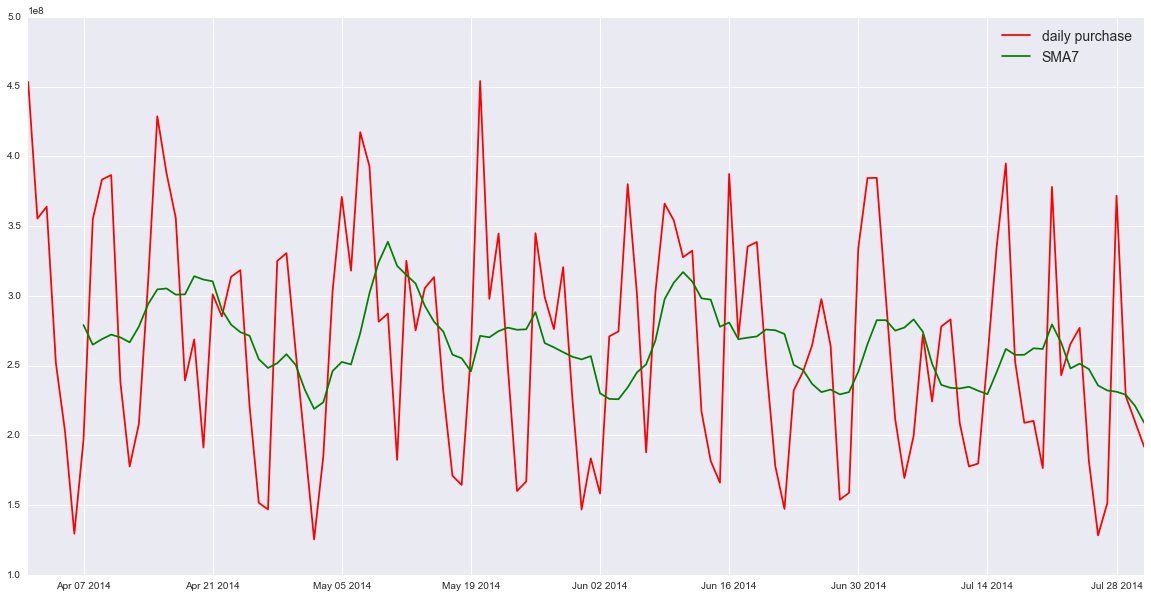

In [21]:
fig = plt.figure(figsize=(20,10))
fig = plt.plot(train_date, train_purchase_data, 'r', label='daily purchase')
fig = plt.plot(train_date, rolling_mean(train_purchase_data, 7), 'g', label='SMA7')
fig = plt.legend(loc='upper right',fontsize=14)

由上图，可以看出，使用移动平均基本能够拟合曲线的趋势。

# 模型2 自回归模型(AR)

自回归模型可以用于预测时间序列将来的值。使用该模型时，通常假定一个随机变量的值依赖于它前面的值。另外，该模型还假定前后值之间的关系是线性的，我们要做的就是拟合数据，以便给数据找到适合的参数。
自回归模型的数学公式如下:
$$X_t = c + \sum_{i=1}^{p} a_i X_{t-i} + \epsilon_t$$

# 模型3 ARIMA模型

ARIMA模型由自回归模型和移动平均模型的基础上加入差分，以使数据在平稳的状态，对数据进行预测。

## 数据分解

1. 购买训练数据集分解

In [22]:
decomposition = seasonal_decompose(train_purchase_data.data, freq=30)

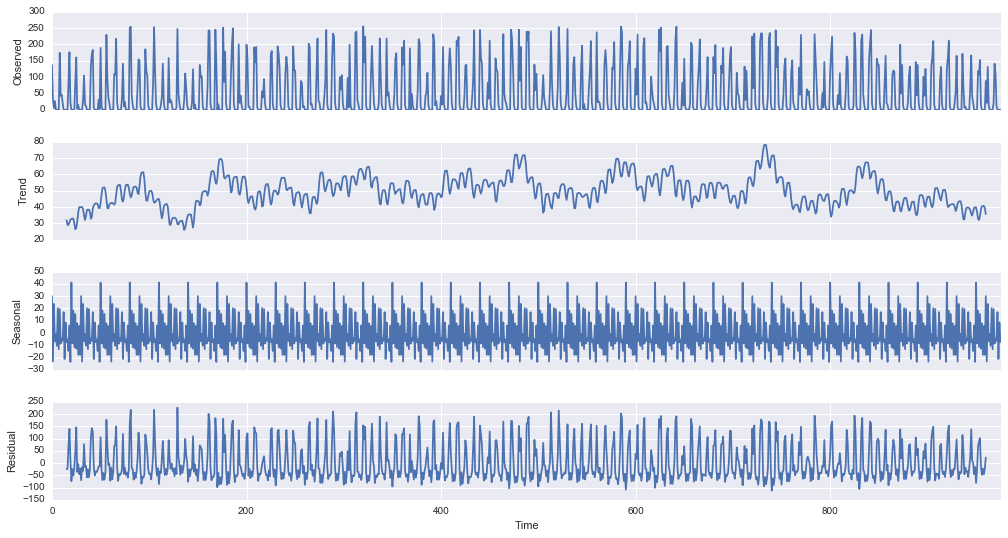

In [23]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

`总结` : 由上图可知购买的趋势不是很明显，而它有很强的周期性，故而在使用模型时周期是个很重要的特征。

## 平稳分析

In [24]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, set_window=30):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=set_window)
    rolstd = pd.rolling_std(timeseries, window=set_window)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(20, 10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

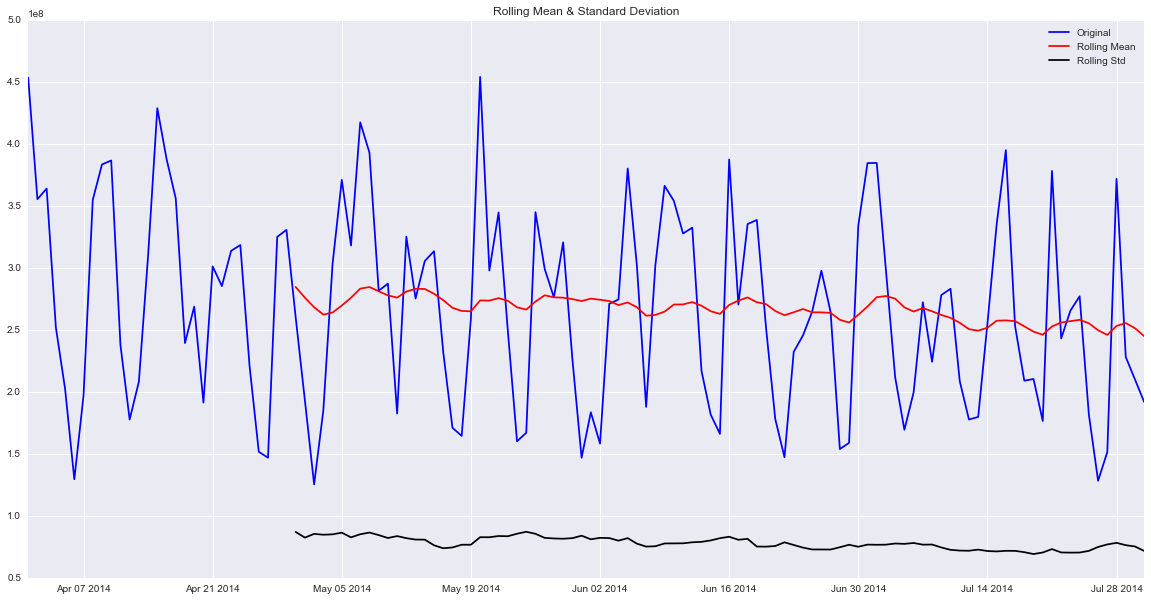

Results of Dickey-Fuller Test:
Test Statistic                  -2.063975
p-value                          0.259245
#Lags Used                      13.000000
Number of Observations Used    108.000000
Critical Value (5%)             -2.888697
Critical Value (1%)             -3.492401
Critical Value (10%)            -2.581255
dtype: float64


In [25]:
test_stationarity(train_purchase_data, 30)

由上图和数据，可以看出，购买数据的平稳性不是很好，下面用一些方法，使数据平稳。

### 1. 差分法

In [34]:
train_purchase_data['first_diff'] = train_purchase_data - train_purchase_data.shift(1)

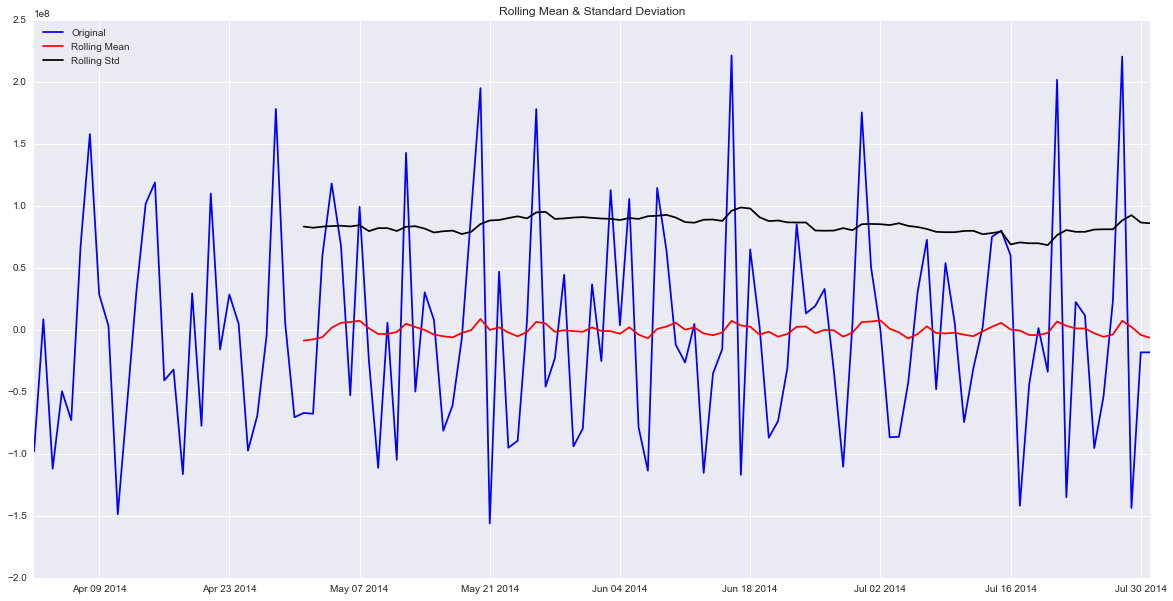

Results of Dickey-Fuller Test:
Test Statistic                -6.506629e+00
p-value                        1.126953e-08
#Lags Used                     1.200000e+01
Number of Observations Used    1.080000e+02
Critical Value (5%)           -2.888697e+00
Critical Value (1%)           -3.492401e+00
Critical Value (10%)          -2.581255e+00
dtype: float64


In [27]:
test_stationarity(train_purchase_data.first_diff.dropna(inplace=False))

### 2. 季节法

In [31]:
train_purchase_data['seasonal_diff'] = train_purchase_data - train_purchase_data.shift(7)

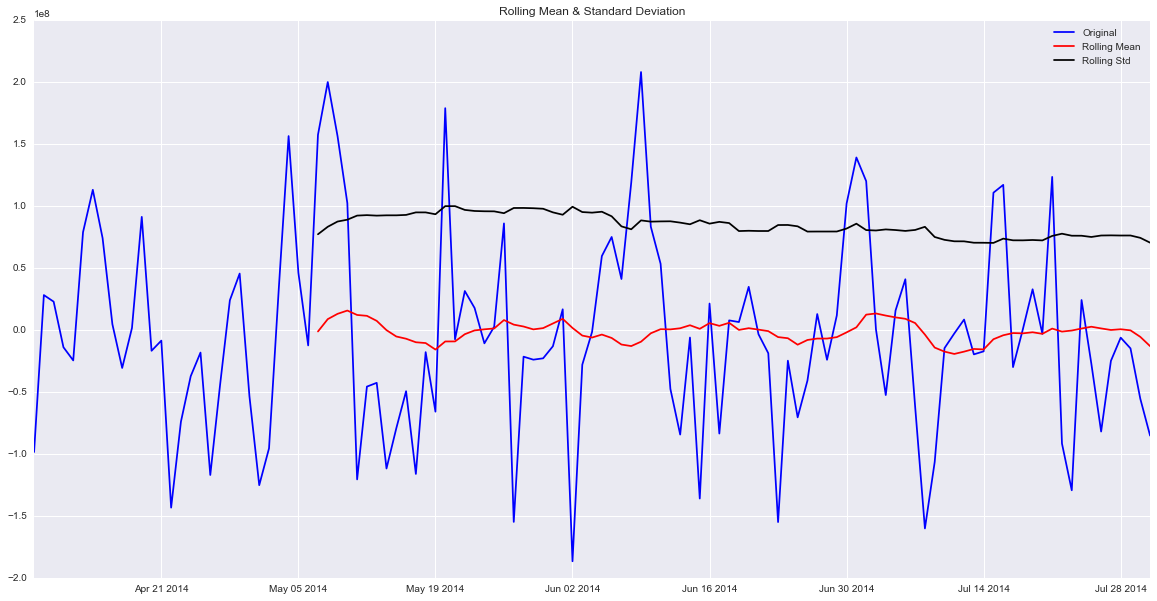

Results of Dickey-Fuller Test:
Test Statistic                  -5.336997
p-value                          0.000005
#Lags Used                      13.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [32]:
test_stationarity(train_purchase_data.seasonal_diff.dropna(inplace=False))

### 3. 差分+季节

In [35]:
train_purchase_data['seasonal_first_diff'] = train_purchase_data.first_diff - train_purchase_data.first_diff.shift(12)

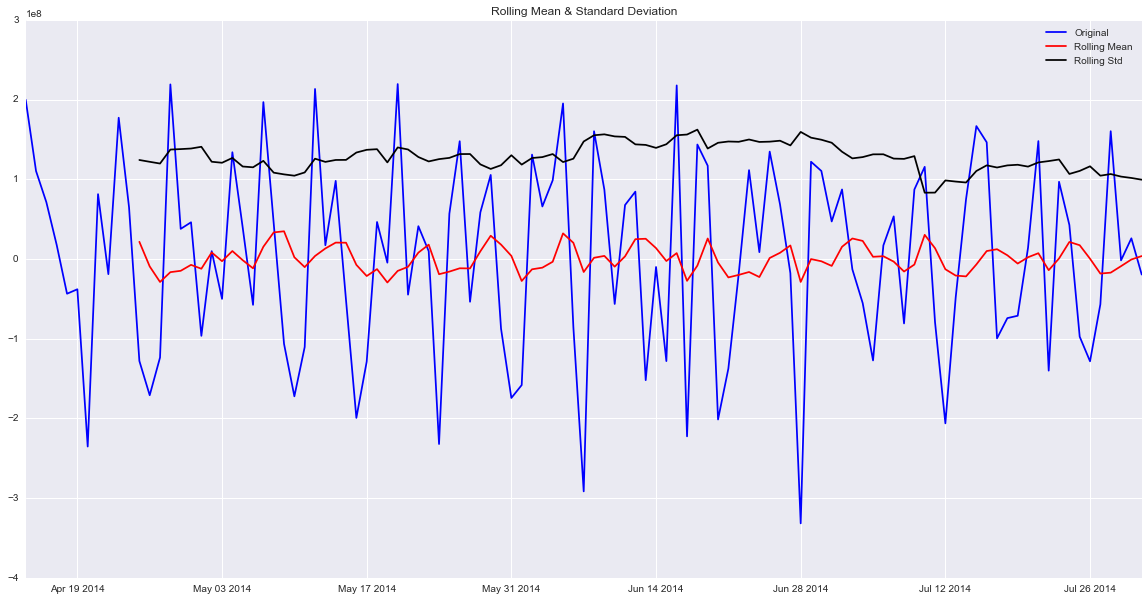

Results of Dickey-Fuller Test:
Test Statistic                -6.128126e+00
p-value                        8.530530e-08
#Lags Used                     1.200000e+01
Number of Observations Used    9.600000e+01
Critical Value (5%)           -2.892152e+00
Critical Value (1%)           -3.500379e+00
Critical Value (10%)          -2.583100e+00
dtype: float64


In [36]:
test_stationarity(train_purchase_data.seasonal_first_diff.dropna(inplace=False), 12)

## 确定最优参数

1. 画自相关和偏相关图


### 购买分析

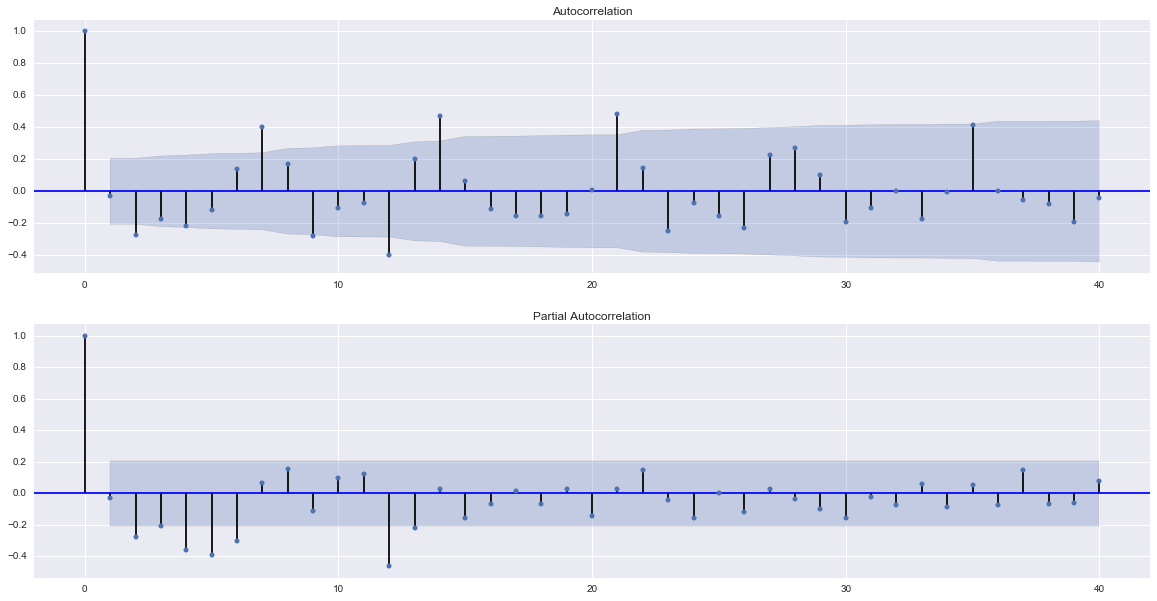

In [37]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_purchase_data.seasonal_first_diff.iloc[31:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_purchase_data.seasonal_first_diff.iloc[31:], lags=40, ax=ax2)

## 构建模型

使用[SARIMAX](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)构建带季节性的ARIMA模型。

In [39]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
seasonal_arima = SARIMAX(train_purchase_data.data, trend='n', order=(1,0,0),seasonal_order=(1,1,1,7))

In [40]:
results = seasonal_arima.fit()

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  976
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 7)   Log Likelihood               -5502.976
Date:                           Mon, 22 Aug 2016   AIC                          11013.952
Time:                                   10:41:20   BIC                          11033.486
Sample:                                        0   HQIC                         11021.385
                                           - 976                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2726      0.027      9.918      0.000       0.219       0.326
ar.S.L7        0.1919      0.031      6.107      0.000       0.130       0.253
ma.S.L7       -0.9996      0.541     -1.848      0.065      -2.060       0.061
sigma2      4854.4948   2567.384      1.891      0.059    -177.485    9886.474
===================================================================================
Ljung-Box (Q):                     2457.98   Jarque-Bera (JB):               304.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             1.32
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
forecast = results.predict(start=123, end=153, dynamic=True)

In [44]:
forecast = forecast * 10000000

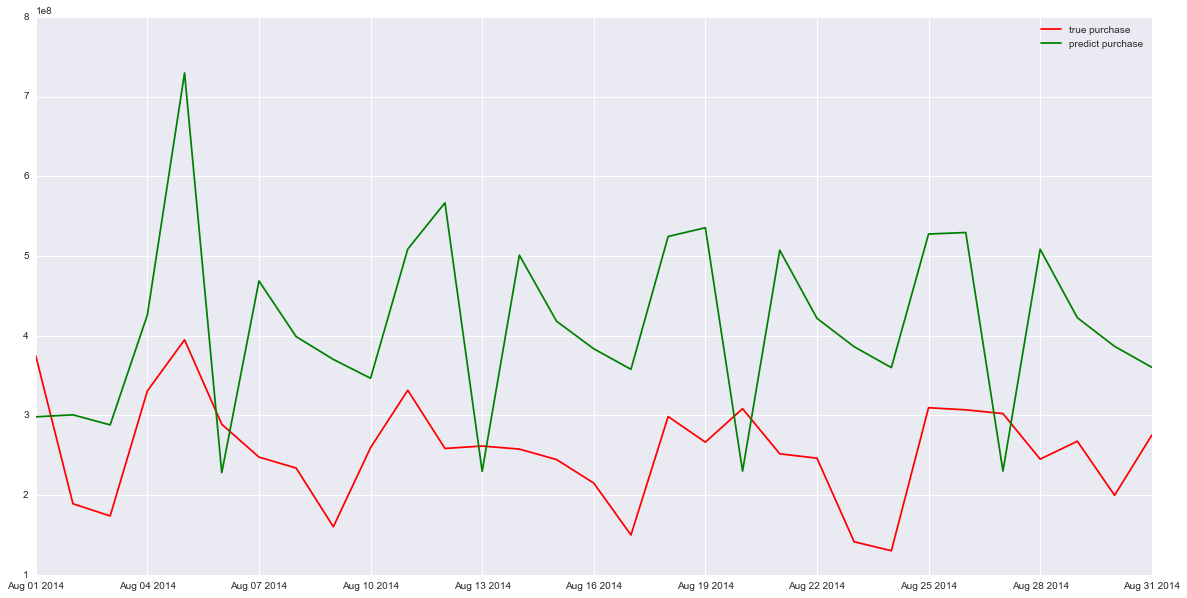

In [45]:
fig = plt.figure(figsize=(20,10))
# spacing = 1
# minorLocator = MultipleLocator(spacing)
ax = fig.add_subplot(1,1,1)
ax.plot(test_date,test_purchase_data.values,'r',label="true purchase")
ax.plot(test_date,forecast,'g', label='predict purchase')
# ax.txaxis.set_minor_locator(minorLocator)
# ax.yaxis.set_minor_locator(minorLocator)
ax.grid(which='minor')
ax.legend(loc='upper right')
plt.show()

## 模型4 ARIMA模型(加入节假日)

加入节假日的ARIMA模型

### 数据处理
1. 加入节假日和周末的

In [46]:
train_purchase_data_holiday = pd.DataFrame({"dt":train_date.values,
                                            "total_purchase":train_purchase_data.values})

In [47]:
test_purchase_data_holiday = pd.DataFrame({"dt":test_date.values,
                                          "total_purchase":test_purchase_data.values})

In [48]:
holidays = [pd.datetime(2014,1,1), pd.datetime(2014,1,4), pd.datetime(2014,1,5), pd.datetime(2014,1,11), pd.datetime(2014,1,12),
            pd.datetime(2014,1,18),pd.datetime(2014,1,19),pd.datetime(2014,1,25),pd.datetime(2014,1,31),pd.datetime(2014,2,1),
            pd.datetime(2014,2,2),pd.datetime(2014,2,3),pd.datetime(2014,2,4),pd.datetime(2014,2,5),pd.datetime(2014,2,6),
            pd.datetime(2014,2,9),pd.datetime(2014,2,15),pd.datetime(2014,2,16),pd.datetime(2014,2,22),pd.datetime(2014,2,23),
            pd.datetime(2014,3,1),pd.datetime(2014,3,8),pd.datetime(2014,3,9),pd.datetime(2014,3,15),pd.datetime(2014,3,16),
            pd.datetime(2014,3,22),pd.datetime(2014,3,23),pd.datetime(2014,3,29),pd.datetime(2014,3,30),pd.datetime(2014,4,5),
            pd.datetime(2014,4,6),pd.datetime(2014,4,7),pd.datetime(2014,4,12),pd.datetime(2014,4,13),pd.datetime(2014,4,19),
            pd.datetime(2014,4,20),pd.datetime(2014,4,26),pd.datetime(2014,4,27),pd.datetime(2014,5,1),pd.datetime(2014,5,2),
            pd.datetime(2014,5,3),pd.datetime(2014,5,3),pd.datetime(2014,5,4),pd.datetime(2014,5,10),pd.datetime(2014,5,11),
            pd.datetime(2014,5,17),pd.datetime(2014,5,18),pd.datetime(2014,5,24),pd.datetime(2014,5,25),pd.datetime(2014,5,31),
            pd.datetime(2014,6,1),pd.datetime(2014,6,2),pd.datetime(2014,6,7),pd.datetime(2014,6,8),pd.datetime(2014,6,14),
            pd.datetime(2014,6,21),pd.datetime(2014,6,22),pd.datetime(2014,6,28),pd.datetime(2014,6,29),pd.datetime(2014,7,5),
            pd.datetime(2014,7,6),pd.datetime(2014,7,12),pd.datetime(2014,7,13),pd.datetime(2014,7,19),pd.datetime(2014,7,20),
            pd.datetime(2014,7,26),pd.datetime(2014,7,27),pd.datetime(2014,8,2),pd.datetime(2014,8,3), pd.datetime(2014,8,9),
            pd.datetime(2014,8,10),pd.datetime(2014,8,16),pd.datetime(2014,8,17),pd.datetime(2014,8,23),pd.datetime(2014,8,24),
            pd.datetime(2014,8,30),pd.datetime(2014,8,31)]

In [49]:
def holiday_judge(x):
    holidays = [pd.datetime(2014,1,1), pd.datetime(2014,1,4), pd.datetime(2014,1,5), pd.datetime(2014,1,11), pd.datetime(2014,1,12),
            pd.datetime(2014,1,18),pd.datetime(2014,1,19),pd.datetime(2014,1,25),pd.datetime(2014,1,31),pd.datetime(2014,2,1),
            pd.datetime(2014,2,2),pd.datetime(2014,2,3),pd.datetime(2014,2,4),pd.datetime(2014,2,5),pd.datetime(2014,2,6),
            pd.datetime(2014,2,9),pd.datetime(2014,2,15),pd.datetime(2014,2,16),pd.datetime(2014,2,22),pd.datetime(2014,2,23),
            pd.datetime(2014,3,1),pd.datetime(2014,3,8),pd.datetime(2014,3,9),pd.datetime(2014,3,15),pd.datetime(2014,3,16),
            pd.datetime(2014,3,22),pd.datetime(2014,3,23),pd.datetime(2014,3,29),pd.datetime(2014,3,30),pd.datetime(2014,4,5),
            pd.datetime(2014,4,6),pd.datetime(2014,4,7),pd.datetime(2014,4,12),pd.datetime(2014,4,13),pd.datetime(2014,4,19),
            pd.datetime(2014,4,20),pd.datetime(2014,4,26),pd.datetime(2014,4,27),pd.datetime(2014,5,1),pd.datetime(2014,5,2),
            pd.datetime(2014,5,3),pd.datetime(2014,5,3),pd.datetime(2014,5,4),pd.datetime(2014,5,10),pd.datetime(2014,5,11),
            pd.datetime(2014,5,17),pd.datetime(2014,5,18),pd.datetime(2014,5,24),pd.datetime(2014,5,25),pd.datetime(2014,5,31),
            pd.datetime(2014,6,1),pd.datetime(2014,6,2),pd.datetime(2014,6,7),pd.datetime(2014,6,8),pd.datetime(2014,6,14),
            pd.datetime(2014,6,21),pd.datetime(2014,6,22),pd.datetime(2014,6,28),pd.datetime(2014,6,29),pd.datetime(2014,7,5),
            pd.datetime(2014,7,6),pd.datetime(2014,7,12),pd.datetime(2014,7,13),pd.datetime(2014,7,19),pd.datetime(2014,7,20),
            pd.datetime(2014,7,26),pd.datetime(2014,7,27),pd.datetime(2014,8,2),pd.datetime(2014,8,3), pd.datetime(2014,8,9),
            pd.datetime(2014,8,10),pd.datetime(2014,8,16),pd.datetime(2014,8,17),pd.datetime(2014,8,23),pd.datetime(2014,8,24),
            pd.datetime(2014,8,30),pd.datetime(2014,8,31)]
    
    if x in holidays:
        return 1
    else:
        return 0

In [50]:
train_purchase_data_holiday['is_holiday'] = train_purchase_data_holiday['dt'].apply(lambda x : holiday_judge(x))

In [51]:
test_purchase_data_holiday['is_holiday'] = test_purchase_data_holiday['dt'].apply(lambda x : holiday_judge(x))

In [52]:
purchase_model = pf.ARIMAX(data=train_purchase_data_holiday, formula='total_purchase~1+is_holiday', ar=2, ma=7)
x = purchase_model.fit()
x.summary()

ARIMAX(2,0,7)                                                                                             
======================================================= ==================================================
Dependent Variable: total_purchase                      Method: MLE                                       
Start Date: 7                                           Log Likelihood: -2224.5014                        
End Date: 121                                           AIC: 4473.0028                                    
Number of observations: 115                             BIC: 4505.942                                     
Parameter                                Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.7262     0.0025     290.0652 0.0      (0.7212 | 0.7311)        
AR(2)                                

In [220]:
# purchase_model.plot_predict_is(31,figsize=(15,5))

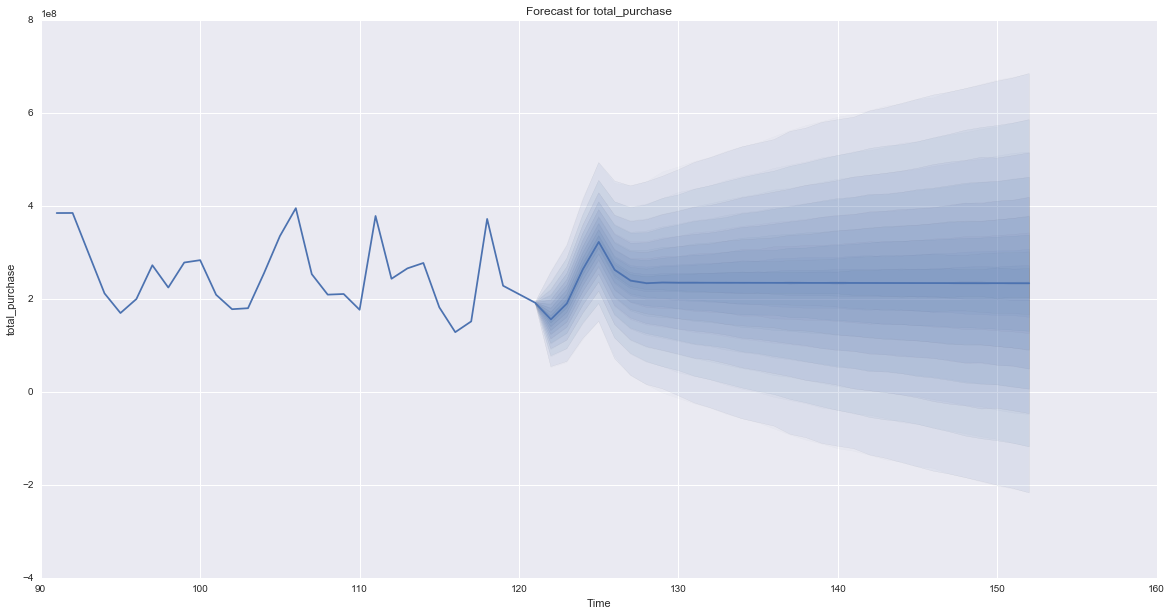

In [53]:
purchase_model.plot_predict(h=31,oos_data=test_purchase_data_holiday.iloc[-31:],past_values=31, figsize=(20,10))

In [54]:
purchase_predict = purchase_model.predict(h=31, oos_data=test_purchase_data_holiday.iloc[-31:])

In [55]:
purchase_test_predict = pd.DataFrame({
        "dt": test_date,
        "true_purchase": test_purchase_data.values,
        "predict_purchase": purchase_predict.total_purchase.values,
    })

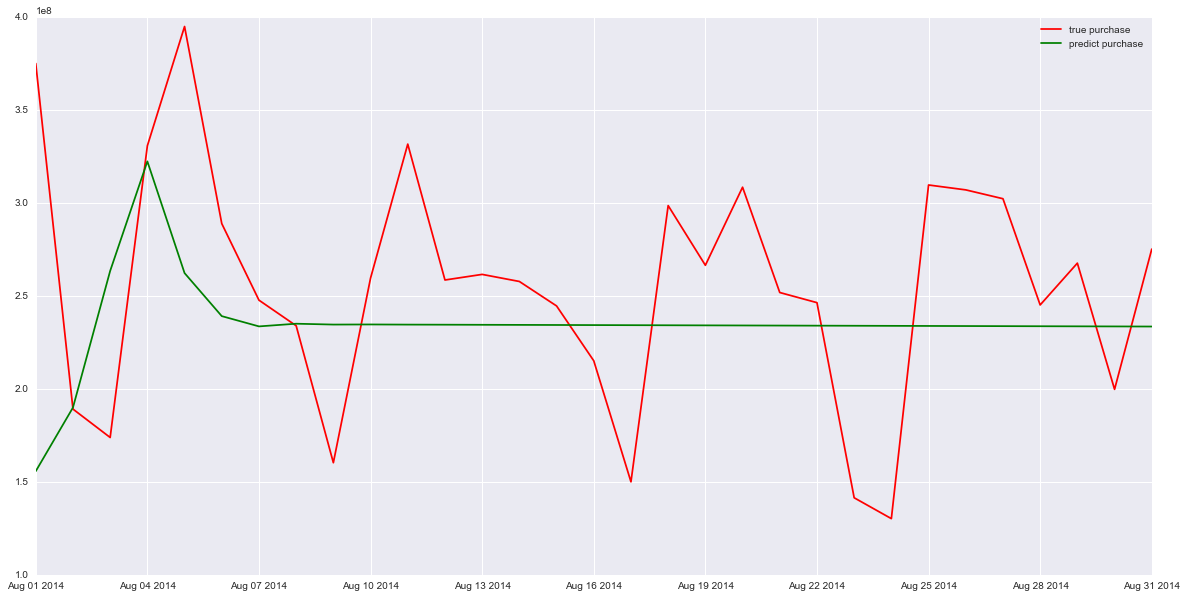

In [56]:
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(20,10))
# spacing = 1
# minorLocator = MultipleLocator(spacing)
ax = fig.add_subplot(1,1,1)
ax.plot(purchase_test_predict.dt,purchase_test_predict.true_purchase,'r',label="true purchase")
ax.plot(purchase_test_predict.dt,purchase_test_predict.predict_purchase,'g', label='predict purchase')
# ax.xaxis.set_minor_locator(minorLocator)
# ax.yaxis.set_minor_locator(minorLocator)
ax.grid(which='minor')
ax.legend(loc='upper right')
plt.show()

## 模型5 神经网路模型

使用神经网络模型构建非线性模型。

### 特征提取

friday,monday,saturday,sunday,thursday,tuesday,wednesday,holiday_3,bom_1,changetowork,
eom_1,eom_2,holiday_1,holiday_2,bom_2,holiday_af_1,holiday_af_2,holiday_af_3,
holiday_pre_1,holiday_pre_2,holiday_pre_3

### 模型构建

使用Google深度学习框架[TensorFlow](https://www.tensorflow.org/)构建3层网络的非线性模型。

In [57]:
nn_file = "nn_purchase_data.csv"

In [58]:
nn_data = pd.read_csv(nn_file)

In [59]:
nn_data.columns = ['friday','monday','saturday','sunday','thursday','tuesday','wednesday','holiday_3','bom_1','changetowork','eom_1','eom_2','holiday_1','holiday_2','bom_2','holiday_af_1','holiday_af_2','holiday_af_3','holiday_pre_1','holiday_pre_2','holiday_pre_3','report_date','daily_purchase']

In [60]:
nn_data['report_date'] = nn_data['report_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

In [61]:
nn_train_data = nn_data[nn_data.report_date <= train_end_date]

In [62]:
nn_test_data = nn_data[nn_data.report_date >= test_start_date]

In [63]:
import tensorflow as tf

In [70]:
purchase_min = np.min(nn_train_data.daily_purchase)

In [73]:
purchase_max = np.max(nn_train_data.daily_purchase)

In [81]:
def purchase_norm(x):
    purchase_min = np.min(x)
    purchase_max = np.max(x)
    return (x - purchase_min) / (purchase_max - purchase_min)

In [82]:
# 标准化购买
nn_train_data['purchase_norm'] = purchase_norm(nn_train_data.daily_purchase)

/Users/EricDoug/Documents/venv/pyhon/venv/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,friday,monday,saturday,sunday,thursday,tuesday,wednesday,holiday_3,bom_1,changetowork,...,bom_2,holiday_af_1,holiday_af_2,holiday_af_3,holiday_pre_1,holiday_pre_2,holiday_pre_3,report_date,daily_purchase,purchase_norm
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,2014-04-01,453320585,0.998069
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,2014-04-02,355347118,0.699932
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,2014-04-03,363877120,0.725889
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,2014-04-04,251895894,0.385126
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2014-04-05,202336542,0.234315
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2014-04-06,129477254,0.012601
6,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,2014-04-07,196936223,0.217881
7,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,2014-04-08,354770149,0.698176
8,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,2014-04-09,383347565,0.785138
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,2014-04-10,386567460,0.794936


In [84]:
trainsize = len(nn_train_data)
testsize = len(nn_test_data)
predictors = nn_train_data.iloc[:, :21]
targets = nn_train_data.iloc[:, 23]
npredictors = len(predictors.columns)  # 1
noutputs = 1
nhidden = 31
numiter = 10000
modelfile_nn3 = 'models/nn3'

In [85]:

with tf.Session() as sess:
    feature_data = tf.placeholder("float", [None, npredictors])
    target_data = tf.placeholder("float", [None, noutputs])
    weights1 = tf.Variable(tf.truncated_normal([npredictors, nhidden], stddev=0.01))
    weights2 = tf.Variable(tf.truncated_normal([nhidden, noutputs], stddev=0.01))
    biases1 = tf.Variable(tf.ones([nhidden]))
    biases2 = tf.Variable(tf.ones([noutputs]))

    model = tf.matmul(tf.nn.relu(tf.matmul(feature_data, weights1) + biases1), weights2) + biases2
    cost = tf.nn.l2_loss(model - target_data)
    training_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
    init = tf.initialize_all_variables()
    sess.run(init)
    
    saver = tf.train.Saver({'weights1': weights1, 'biases1': biases1, 'weights2': weights2, 'biases2': biases2})
    
    for iter in xrange(0, numiter):
        sess.run(training_step, feed_dict = {
                feature_data: predictors[: trainsize].values,
                target_data: targets[:trainsize].values.reshape(trainsize, noutputs)
            })
        
        if iter%100 == 0:
            print '{0} error={1}'.format(iter, np.sqrt(cost.eval(feed_dict = {
                            feature_data: predictors[:trainsize].values,
                            target_data: targets[:trainsize].values.reshape(trainsize,noutputs)
                        }) / trainsize))
            
    filename = saver.save(sess, modelfile_nn3, global_step=numiter)
    print "Model written to {0}".format(filename)
    
    print 'testerror={0}'.format(np.sqrt(cost.eval(feed_dict = {
                    feature_data: predictors[:trainsize].values,
                    target_data: targets[:trainsize].values.reshape(trainsize, noutputs)
                }) /trainsize))

0 error=0.445776087263
100 error=0.268353157664
200 error=0.187477099995
300 error=0.169114412028
400 error=0.164049593249
500 error=0.160351353366
600 error=0.156899350504
700 error=0.153572906092
800 error=0.150332359379
900 error=0.147156182325
1000 error=0.144030554285
1100 error=0.140945805182
1200 error=0.137895190444
1300 error=0.134874723416
1400 error=0.131883786012
1500 error=0.128926381237
1600 error=0.126012783586
1700 error=0.123161328202
1800 error=0.120399628071
1900 error=0.117764429645
2000 error=0.115299283948
2100 error=0.113049323094
2200 error=0.111053927834
2300 error=0.10933904928
2400 error=0.107912035144
2500 error=0.106760426934
2600 error=0.105855541726
2700 error=0.105158899048
2800 error=0.104629256042
2900 error=0.104228220925
3000 error=0.103923495533
3100 error=0.103689786438
3200 error=0.103508365847
3300 error=0.103365831344
3400 error=0.10325272009
3500 error=0.103162318914
3600 error=0.103089787346
3700 error=0.103031521427
3800 error=0.102984760664


In [86]:
test_cols = nn_test_data.iloc[:, :21].shape[1]

In [87]:
with tf.Session() as sess:
    filename = modelfile_nn3 + '-' + str(numiter)
    print filename
    saver = tf.train.Saver({'weights1': weights1, 'biases1': biases1, 'weights2': weights2, 'biases2': biases2})
    saver.restore(sess, filename)
    feature_data = tf.placeholder("float", [None, test_cols])
    predict_operation = tf.matmul(tf.nn.relu(tf.matmul(feature_data, weights1) + biases1), weights2) + biases2
    
    predicted = sess.run(predict_operation, feed_dict = {
            feature_data: nn_test_data.iloc[:,:21].values
        })
    
    nn_test_data['nn_predict'] = predicted

models/nn3-10000


/Users/EricDoug/Documents/venv/pyhon/venv/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [88]:
def repair_norm(x):
    return x*(purchase_max - purchase_min) + purchase_min

In [89]:
nn_test_data['nn_predict_repair'] = repair_norm(nn_test_data['nn_predict'])

/Users/EricDoug/Documents/venv/pyhon/venv/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


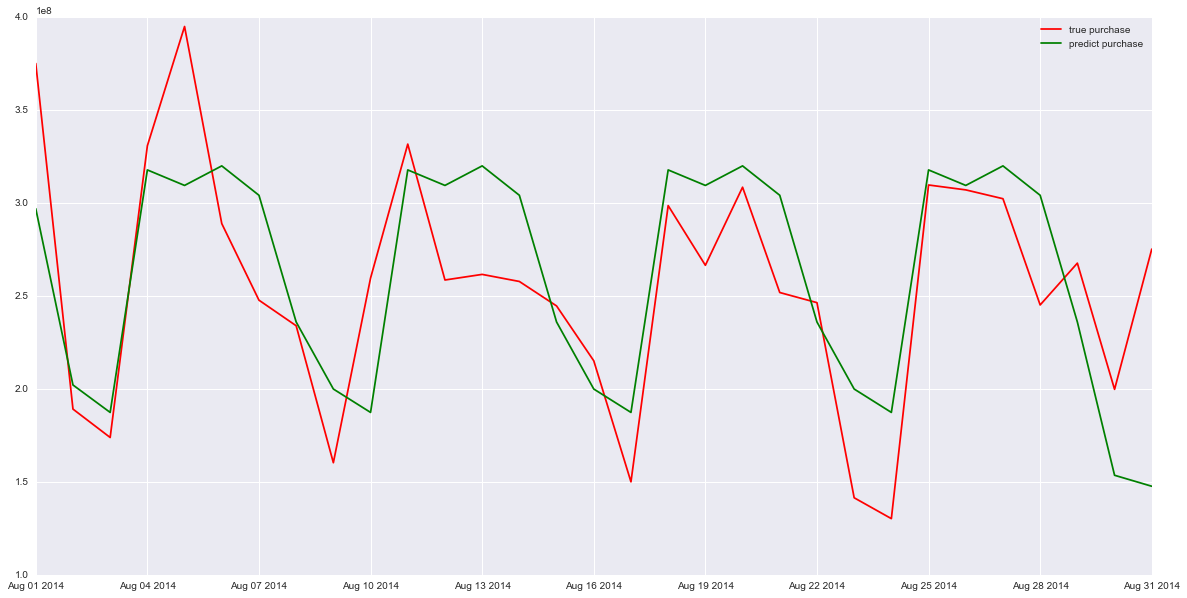

In [90]:
fig = plt.figure(figsize=(20,10))
# spacing = 1
# minorLocator = MultipleLocator(spacing)
ax = fig.add_subplot(1,1,1)
ax.plot(test_date,nn_test_data.daily_purchase,'r',label="true purchase")
ax.plot(test_date,nn_test_data.nn_predict_repair,'g', label='predict purchase')
# ax.txaxis.set_minor_locator(minorLocator)
# ax.yaxis.set_minor_locator(minorLocator)
ax.grid(which='minor')
ax.legend(loc='upper right')
plt.show()